In [1]:
!pip install yfinance nltk vaderSentiment requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.6 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [6]:
start_date = "2025-02-05"
end_date = datetime.now().strftime('%Y-%m-%d')

nvidia_stock = yf.Ticker('NVDA')
stock_data = nvidia_stock.history(start=start_date, end=end_date)
stock_data.reset_index(inplace=True)
stock_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-02-05 00:00:00-05:00,121.748802,124.988502,120.748894,124.818520,262230800,0.0,0.0
1,2025-02-06 00:00:00-05:00,127.408273,128.758155,125.198478,128.668152,251483600,0.0,0.0
2,2025-02-07 00:00:00-05:00,129.208111,130.357999,124.988498,129.828049,228186300,0.0,0.0
3,2025-02-10 00:00:00-05:00,130.078033,134.987585,129.948055,133.557724,216989100,0.0,0.0
4,2025-02-11 00:00:00-05:00,132.567815,134.467634,131.007961,132.787796,178902400,0.0,0.0


In [10]:
import requests
from google.colab import userdata

api_key = userdata.get('NEWS_API_KEY')
if not api_key:
  raise KeyError('News API Key not found!')

url = 'https://newsapi.org./v2/everything'
params = {
    'q': 'Nvidia',
    'from': (datetime.now() - timedelta(days=28)).strftime('%Y-%m-%d'),
    'sortBy': 'relevancy',
    'pageSize': 100,
    'language': 'en',
    'apiKey': api_key
}

response = requests.get(url, params=params)
data = response.json()

if data['status'] != 'ok':
  raise Exception(f"News API Error: {data['message']}")

articles = data['articles']
news_data = pd.DataFrame(articles)
news_data.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': 'the-verge', 'name': 'The Verge'}",Jess Weatherbed,Nvidia’s new tool can turn 3D scenes into AI i...,Nvidia launched a new tool that lets developer...,https://www.theverge.com/news/658613/nvidia-ai...,https://platform.theverge.com/wp-content/uploa...,2025-04-30T13:19:12Z,Nvidias AI Blueprint for 3D-guided generative ...
1,"{'id': 'the-verge', 'name': 'The Verge'}",Antonio G. Di Benedetto,Lenovo’s flagship gaming laptop has a 2D / 3D ...,Lenovo is announcing a new 10th-generation Leg...,https://www.theverge.com/news/663084/lenovo-le...,https://platform.theverge.com/wp-content/uploa...,2025-05-08T09:38:37Z,"The new Legion 9i doesnt have a price yet, but..."
2,"{'id': 'the-verge', 'name': 'The Verge'}",Jess Weatherbed,Nvidia’s flattery of Trump wins reversal of AI...,Nvidia’s efforts to suck up to the Trump admin...,https://www.theverge.com/news/666605/nvidias-f...,https://platform.theverge.com/wp-content/uploa...,2025-05-14T10:40:56Z,"Trump (center) and Jensen Huang (lower level, ..."
3,"{'id': 'the-verge', 'name': 'The Verge'}",Jay Peters,Switch 2 spec breakdown digs into its processo...,Nintendo’s Switch 2 specs page is light on det...,https://www.theverge.com/news/667094/nintendo-...,https://platform.theverge.com/wp-content/uploa...,2025-05-14T17:51:34Z,Digital Foundry has some more details about th...
4,"{'id': 'wired', 'name': 'Wired'}",Chris Baraniuk,The Climate Crisis Threatens Supply Chains. Ma...,The Covid-19 pandemic showed just how vulnerab...,https://www.wired.com/story/manufacturers-hope...,https://media.wired.com/photos/67bde52c1171429...,2025-05-02T10:00:00Z,"Abhi Ghadge, associate professor of supply cha..."


In [11]:
news_data = news_data[['publishedAt', 'title']]
news_data.columns = ['date', 'headline']

In [12]:
news_data.head()

,date,headline
0,2025-04-30T13:19:12Z,Nvidia’s new tool can turn 3D scenes into AI i...
1,2025-05-08T09:38:37Z,Lenovo’s flagship gaming laptop has a 2D / 3D ...
2,2025-05-14T10:40:56Z,Nvidia’s flattery of Trump wins reversal of AI...
3,2025-05-14T17:51:34Z,Switch 2 spec breakdown digs into its processo...
4,2025-05-02T10:00:00Z,The Climate Crisis Threatens Supply Chains. Ma...


In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [15]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
  words = word_tokenize(text)
  word = [ word for word in words if word.isalpha() ]
  words = [ word for word in words if word.lower() not in stop_words ]
  return ' '.join(words)

news_data['cleaned_headline'] = news_data['headline'].apply(preprocess_text)

In [17]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
  score = analyzer.polarity_scores(text)
  return score['compound']

news_data['sentiment_score'] = news_data['cleaned_headline'].apply(get_sentiment_score)
news_data.head()

,date,headline,cleaned_headline,sentiment_score
0,2025-04-30T13:19:12Z,Nvidia’s new tool can turn 3D scenes into AI i...,Nvidia ’ new tool turn 3D scenes AI images,0.0000
1,2025-05-08T09:38:37Z,Lenovo’s flagship gaming laptop has a 2D / 3D ...,Lenovo ’ flagship gaming laptop 2D / 3D screen...,0.1027
2,2025-05-14T10:40:56Z,Nvidia’s flattery of Trump wins reversal of AI...,Nvidia ’ flattery Trump wins reversal AI chip ...,0.6249
3,2025-05-14T17:51:34Z,Switch 2 spec breakdown digs into its processo...,Switch 2 spec breakdown digs processor GameChat,0.0000
4,2025-05-02T10:00:00Z,The Climate Crisis Threatens Supply Chains. Ma...,Climate Crisis Threatens Supply Chains . Manuf...,-0.2732


In [20]:
# converting into datetime objects
news_data['date'] = pd.to_datetime(news_data['date']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

In [21]:
# aggregating sentiment scores by date
aggregated_sentiment = news_data.groupby('date')['sentiment_score'].sum().reset_index()
aggregated_sentiment.head()

,date,sentiment_score
0,2025-04-28,-0.1280
1,2025-04-29,-0.3182
2,2025-04-30,-0.0343
3,2025-05-01,0.2557
4,2025-05-02,-0.2944


In [22]:
# merging stock data with aggregated sentiment score
combined_data = pd.merge(
  stock_data, aggregated_sentiment,
  left_on='Date', right_on='date',
  how='inner'
)
combined_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,sentiment_score
0,2025-04-28,109.690002,110.370003,106.019997,108.730003,207708500,0.0,0.0,2025-04-28,-0.1280
1,2025-04-29,107.669998,110.199997,107.440002,109.019997,170444300,0.0,0.0,2025-04-29,-0.3182
2,2025-04-30,104.470001,108.919998,104.080002,108.919998,235044600,0.0,0.0,2025-04-30,-0.0343
3,2025-05-01,113.080002,114.940002,111.300003,111.610001,236121500,0.0,0.0,2025-05-01,0.2557
4,2025-05-02,114.180000,115.400002,113.370003,114.500000,190194800,0.0,0.0,2025-05-02,-0.2944


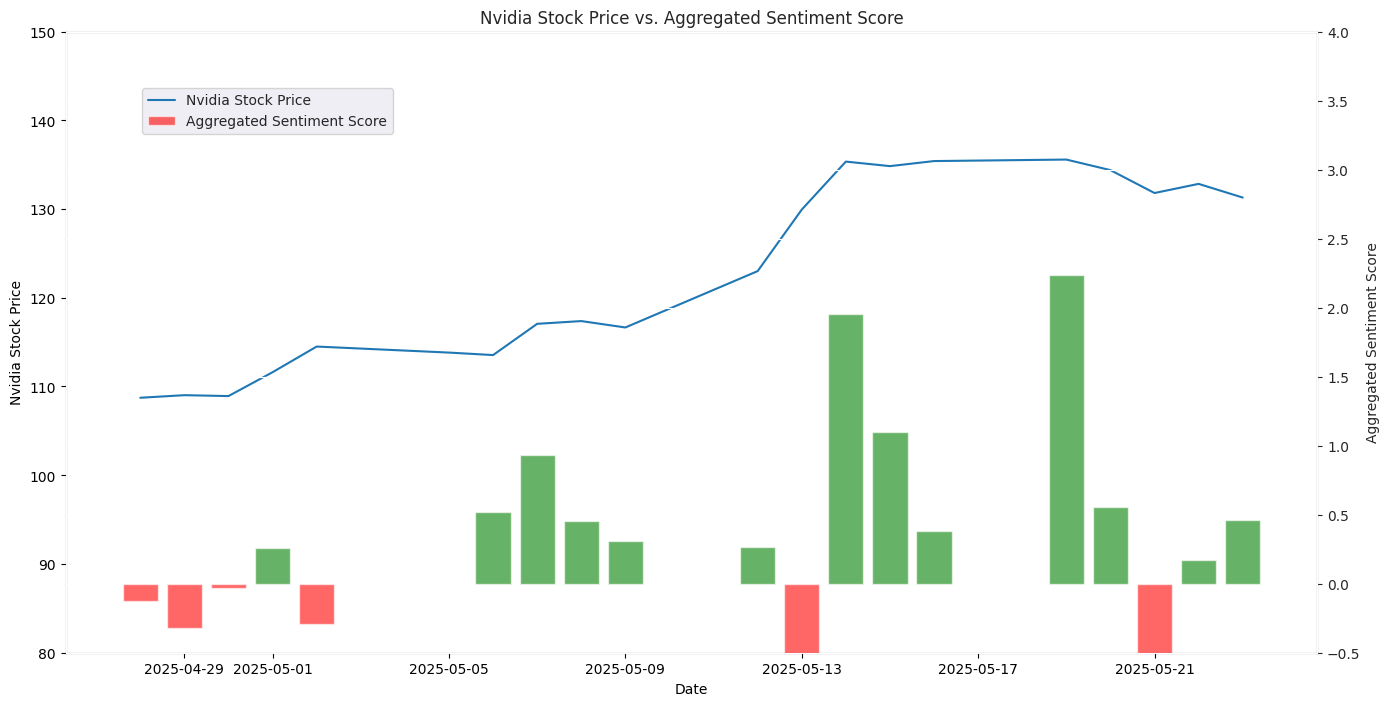

In [31]:
# visualizing the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Nvidia Stock Price')
ax1.plot(combined_data['Date'], combined_data['Close'], label='Nvidia Stock Price')
ax1.tick_params(axis='y')
ax1.set_ylim(80, 150)

ax2 = ax1.twinx()
ax2.set_ylabel('Aggregated Sentiment Score')

colours = [ 'green' if value >= 0 else 'red' for value in combined_data['sentiment_score'] ]

ax2.bar(
  combined_data['Date'], combined_data['sentiment_score'],
  label='Aggregated Sentiment Score', color=colours, alpha=0.6
)
ax2.tick_params(axis='y')
ax2.set_ylim(-0.5, 4)

fig.tight_layout()
plt.title('Nvidia Stock Price vs. Aggregated Sentiment Score')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()